# 学習済みモデルの特徴空間・プロトタイプを可視化

In [1]:
from pathlib import Path
import os, sys, json
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# 例: 物理GPU1番だけを見せる
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [3]:
# === プロジェクトルートの指定 ===
# Notebook を CIDL-main の直下で開いているなら "." で OK
PROJECT_ROOT = Path("/home/kouyou/ContinualLearning/repexp/PyCIL").resolve()
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

from trainer import _set_device  # 既存のヘルパをそのまま使う
from utils.data_manager import DataManager
from utils import factory

# === 使いたい設定ファイルと、どの phase を可視化するか ===
CONFIG_PATH = "exps/der_mu/baseline0/cifar100.json"   # 適宜変更
PHASE_ID    = 5                                         # ex) タスク3終了時のモデル → phase3.pkl

# === json 読み込み → args にする ===
with open(CONFIG_PATH) as f:
    args = json.load(f)

# device を training と同じ形式 (list of torch.device) に変換
_set_device(args)

print("model_name:", args["model_name"])
print("dataset   :", args["dataset"])
print("device    :", args["device"])

model_name: der-mu
dataset   : cifar100
device    : [device(type='cuda', index=0)]


## チェックポイントの設定

In [4]:
from glob import glob

def build_ckpt_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

ckpt_dir  = build_ckpt_dir(args)
ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}.pkl"

print("ckpt_dir :", ckpt_dir)
print("ckpt_path:", ckpt_path)

# # もし exists が False のときは、pattern で探す fallback も書いておくと楽
# if not ckpt_path.exists():
#     cand = glob(str(ckpt_dir / f"phase{PHASE_ID}*.pkl"))
#     print("fallback candidates:", cand)


ckpt_dir : logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/
ckpt_path: logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32//phase_5.pkl


## データマネージャーとモデルの作成

In [5]:
# === DataManager & model を構築 ===
data_manager = DataManager(
    dataset_name=args["dataset"],
    shuffle=args["shuffle"],
    seed=args["seed"][0],
    init_cls=args["init_cls"],
    increment=args["increment"],
)

model = factory.get_model(args["model_name"], args)
model._network.to(args["device"][0])
model._device = args["device"][0]

# # === checkpoint ロード ===
# ckpt = torch.load(ckpt_path, map_location=model._device)
# state_dict = ckpt["model_state_dict"]

# # 1) checkpoint から fc の出力次元を読む
# if "fc.weight" in state_dict:
#     out_dim = state_dict["fc.weight"].shape[0]  # logits の次元数
#     # 2) その次元数に合わせて fc を作成
#     model._network.update_fc(out_dim)

# # 3) その上で state_dict をロード
# model._network.load_state_dict(state_dict)

# # protos, forget_classes も保存されていれば復元
# if "protos" in ckpt:
#     model._protos = ckpt["protos"]
# if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
#     model.forget_classes = ckpt["forget_classes"]

# model.data_manager = data_manager

# # model.forget_classes = [0, 1]

# print("loaded tasks =", ckpt.get("tasks", "N/A"))
# print("forget_classes:", getattr(model, "forget_classes", None))


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# === checkpoint ロード ===
ckpt = torch.load(ckpt_path, map_location=model._device)
state_dict = ckpt["model_state_dict"]

# 1) checkpoint から fc の出力次元を読む
if "fc.weight" in state_dict:
    out_dim = state_dict["fc.weight"].shape[0]  # logits の次元数

    # DER のように convnets.* が複数ある checkpoint かどうか
    has_multi_convnets_in_ckpt = any(k.startswith("convnets.1.") for k in state_dict.keys())
    is_expandable_like_der = hasattr(model._network, "convnets") and hasattr(model._network, "update_fc")

    if has_multi_convnets_in_ckpt and is_expandable_like_der:
        # --- 変更点(重要): 既存ネットがすでに update_fc 済みだと単調増加が壊れるので、
        #                  "空のネット" を作り直してから update_fc を回す ---
        net_cls = model._network.__class__
        try:
            model._network = net_cls(args, pretrained=False)
        except TypeError:
            model._network = net_cls(args, False)

        # checkpoint 側の branch 数 (= convnets の本数) を推定
        branch_ids = []
        for k in state_dict.keys():
            if k.startswith("convnets."):
                parts = k.split(".")
                if len(parts) > 1 and parts[1].isdigit():
                    branch_ids.append(int(parts[1]))
        n_branches = (max(branch_ids) + 1) if branch_ids else 1

        # 保存時と同じ回数だけ update_fc（最後は out_dim に合わせる）
        total = 0
        for t in range(n_branches):
            if t == 0:
                total = min(args["init_cls"], out_dim)
            else:
                total = min(total + args["increment"], out_dim)

            if t == n_branches - 1:
                total = out_dim  # 最終的に checkpoint の fc 出力次元へ一致させる

            model._network.update_fc(total)

        model._network.to(args["device"][0])

    else:
        # 従来どおり（DER 以外はここを通る）
        model._network.update_fc(out_dim)

# 3) その上で state_dict をロード
model._network.load_state_dict(state_dict)

# protos, forget_classes も保存されていれば復元
if "protos" in ckpt:
    model._protos = ckpt["protos"]
if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
    model.forget_classes = ckpt["forget_classes"]


<ipython-input-6-ddc0ab3b284e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=model._device)


## 学習済みクラスなどの設定・確認

In [7]:
# === この phase で「見えている」クラス数を計算 ===
num_classes = args["init_cls"] + PHASE_ID * args["increment"]
num_classes = min(num_classes, data_manager.get_total_classnum())

# その時点での全クラス（モデルのラベル空間）
all_seen = np.arange(num_classes)

# MU 系モデルの場合：忘却クラス集合（relabel 後の ID）
forget_set = set(getattr(model, "forget_classes", []))

# 現在 phase で実際に存在する忘却クラスだけに絞る
forget = np.array(
    sorted([c for c in forget_set if c < num_classes]),
    dtype=int
)

# retain クラス = all_seen - forget
retain = np.setdiff1d(all_seen, forget)

print("num_classes :", num_classes)
print("all_seen    :", all_seen[:10], "... (total", len(all_seen), ")")
print("forget      :", forget)
print("retain      :", retain[:10], "... (total", len(retain), ")")


num_classes : 60
all_seen    : [0 1 2 3 4 5 6 7 8 9] ... (total 60 )
forget      : []
retain      : [0 1 2 3 4 5 6 7 8 9] ... (total 60 )


## 実画像の特徴量の取り出し

In [8]:
import torch
import numpy as np

def _unwrap_net(net):
    return net.module if isinstance(net, torch.nn.DataParallel) else net

def _get_backbone_list(net):
    """
    DER: net.convnets (ModuleList)
    TagFex系: 実装によって名前が違う可能性があるので候補を順に探す
    """
    for name in ["convnets", "backbones", "branches", "encoders", "nets"]:
        if hasattr(net, name):
            m = getattr(net, name)
            if isinstance(m, (torch.nn.ModuleList, list, tuple)):
                return list(m)
    return None

@torch.no_grad()
def extract_vectors_preconcat_by_backbone(model, loader):
    net = _unwrap_net(model._network)
    net.eval()

    backbones = _get_backbone_list(net)
    feats_by_bb = None
    labels_all = []

    for _, _inputs, _targets in loader:
        x = _inputs.to(model._device)
        y = _targets.numpy()
        labels_all.append(y)

        if backbones is None:
            # 非拡張モデルは従来どおり1本として扱う（既存機能を壊さない）
            f = net.extract_vector(x).detach().cpu().numpy()
            if feats_by_bb is None:
                feats_by_bb = [[]]
            feats_by_bb[0].append(f)
        else:
            outs = []
            for bb in backbones:
                o = bb(x)
                f = o["features"] if isinstance(o, dict) and "features" in o else o
                outs.append(f.detach().cpu().numpy())

            if feats_by_bb is None:
                feats_by_bb = [[] for _ in range(len(outs))]
            for i, f in enumerate(outs):
                feats_by_bb[i].append(f)

    feats_by_bb = [np.concatenate(v, axis=0) for v in feats_by_bb]
    labels = np.concatenate(labels_all, axis=0)
    return feats_by_bb, labels


In [14]:
# "all" / "forget" / "retain" / "manual" から選ぶ
TARGET_MODE = "manual"   # ← ここを変える

# manual のときに使うクラスID（モデル側のラベル空間）
MANUAL_CLASSES = [50,51,52,53,54,55,56,57,58,59]   # 例: 最初の数クラスだけ

if TARGET_MODE == "all":
    target_classes = all_seen
elif TARGET_MODE == "forget":
    target_classes = forget
elif TARGET_MODE == "retain":
    target_classes = retain
elif TARGET_MODE == "manual":
    target_classes = np.array(MANUAL_CLASSES, dtype=int)
else:
    raise ValueError("Unknown TARGET_MODE:", TARGET_MODE)

print("target_classes:", target_classes)

from torch.utils.data import DataLoader

# === 指定したクラスだけの test データセット ===
test_dataset = data_manager.get_dataset(
    indices=target_classes,
    source="train",
    mode="test",
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=args["num_workers"],
    pin_memory=True,
)

# === 特徴抽出 ===
# features, labels = model._extract_vectors(test_loader)  # features: (N, D), labels: (N,)
# print("features:", features.shape, "labels:", labels.shape)

# DER / tagfex専用
# BB_ID = [0,1,2,3,4,5,6,7,8,9]   # int でも [..] でもOK（例：[0,1,2] や (5,7) など）
BB_ID = [0,1,2,3,4,5]   # int でも [..] でもOK（例：[0,1,2] や (5,7) など）

# concat 前特徴を指定 backbone 分だけ concat（N は共通の前提）
features_by_bb, labels = extract_vectors_preconcat_by_backbone(model, test_loader)
print("num_backbones:", len(features_by_bb))
print("shapes:", [f.shape for f in features_by_bb])


if isinstance(BB_ID, (list, tuple, set, np.ndarray)):
    bb_ids = list(BB_ID)
else:
    bb_ids = [int(BB_ID)]

# 念のため順序を固定（set を渡しても安定）
bb_ids = [int(i) for i in bb_ids]
bb_ids.sort()

# concat 前特徴を指定 backbone 分だけ concat（N は共通の前提）
features = np.concatenate([features_by_bb[i] for i in bb_ids], axis=1)

print("using BB_ID:", bb_ids)
print("features shape:", features.shape)


# 念のため：本当に target_classes だけか確認
print("unique labels in batch:", np.unique(labels))

target_classes: [50 51 52 53 54 55 56 57 58 59]


num_backbones: 6
shapes: [(5000, 64), (5000, 64), (5000, 64), (5000, 64), (5000, 64), (5000, 64)]
using BB_ID: [0, 1, 2, 3, 4, 5]
features shape: (5000, 384)
unique labels in batch: [50 51 52 53 54 55 56 57 58 59]


## t-sneによる次元削減

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# === subsample (特徴側だけ、必要なら) ===
max_points = 50000
if features.shape[0] > max_points:
    idx = np.random.choice(features.shape[0], max_points, replace=False)
    feat_vis = features[idx]
    labels_vis = labels[idx]
else:
    feat_vis = features
    labels_vis = labels

print("visualizing features:", feat_vis.shape[0])

X_tsne = feat_vis
print("X_tsne.shape: ", X_tsne.shape)

# === t-SNE ===
tsne = TSNE(
    n_components=2,
    init="pca",
    random_state=0,
    perplexity=50,
    learning_rate=200,
)
X_2d = tsne.fit_transform(X_tsne)



# 実画像
feat_2d = X_2d[:feat_vis.shape[0]]





visualizing features: 5000
X_tsne.shape:  (5000, 384)


## 保存先のディレクトリを設定

In [16]:
from glob import glob

def build_plot_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/plot/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

plot_dir  = build_plot_dir(args)

print("plot_dir :", plot_dir)



plot_dir : logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/plot/


## 可視化と保存

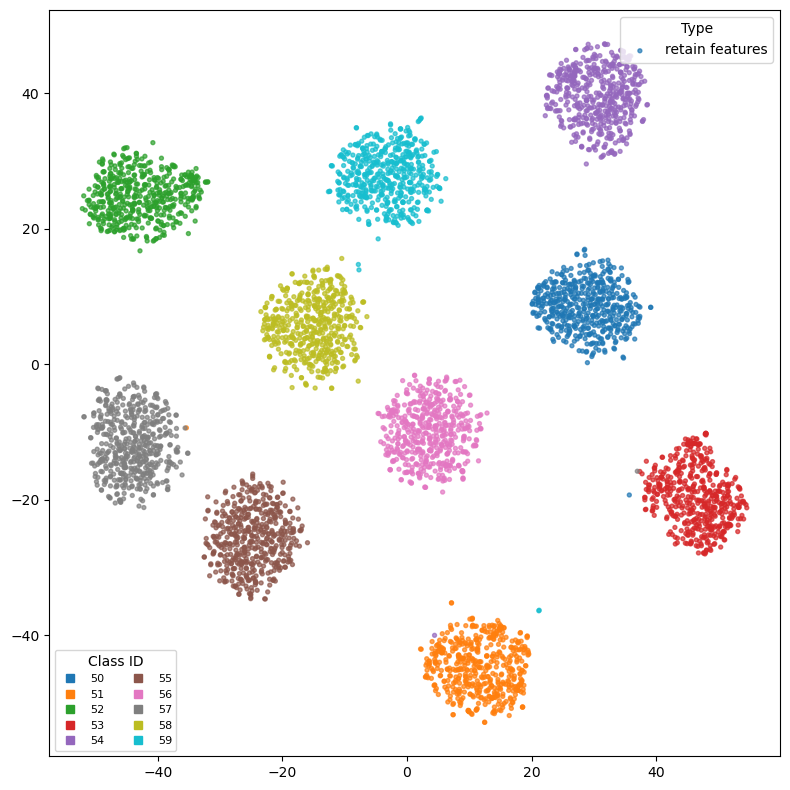

logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/plot/5_[50 51 52 53 54 55 56 57 58 59].pdf


In [17]:
from matplotlib.lines import Line2D  # まだインポートしてなければ追加

plt.figure(figsize=(8, 8))

# === 忘却クラス集合 ===
forget_set = set(getattr(model, "forget_classes", []))

# === 実画像 feature のうち忘却 / 維持に分割 ===
is_forget_feat = np.isin(labels_vis, list(forget_set))
idx_feat_forget = np.where(is_forget_feat)[0]
idx_feat_retain = np.where(~is_forget_feat)[0]


# === 色を割り当てる対象となる全クラスID ===
all_label_values = [labels_vis]


all_label_values = np.concatenate(all_label_values)
unique_labels = np.unique(all_label_values)

# === クラスごとの色をはっきり決める ===
# クラス数に応じて tab10 / tab20 を使い分け
if len(unique_labels) <= 10:
    cmap = plt.get_cmap("tab10")
else:
    cmap = plt.get_cmap("tab20")

# cls -> color の辞書
cls_color = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_labels)}

# === 維持クラスの実画像特徴（小さい丸） ===
if len(idx_feat_retain) > 0:
    colors_retain = [cls_color[int(lbl)] for lbl in labels_vis[idx_feat_retain]]
    plt.scatter(
        feat_2d[idx_feat_retain, 0],
        feat_2d[idx_feat_retain, 1],
        c=colors_retain,
        s=8,
        alpha=0.7,
        marker="o",
        label="retain features",
    )

# === 忘却クラスの実画像特徴（小さい ×） ===
if len(idx_feat_forget) > 0:
    colors_forget = [cls_color[int(lbl)] for lbl in labels_vis[idx_feat_forget]]
    plt.scatter(
        feat_2d[idx_feat_forget, 0],
        feat_2d[idx_feat_forget, 1],
        c=colors_forget,
        s=16,
        alpha=0.8,
        marker="x",
        linewidths=0.8,
        label="forget features",
    )



# === legend を2段構成にする ===
handles_type, labels_type = plt.gca().get_legend_handles_labels()
type_legend = plt.legend(
    handles_type,
    labels_type,
    loc="upper right",
    title="Type",
)
plt.gca().add_artist(type_legend)  # この legend を固定

# 2) クラスIDごとの色 legend
class_handles = []
for cls in unique_labels:
    h = Line2D(
        [], [],
        marker="s", linestyle="",
        color=cls_color[cls],
        label=str(cls),
    )
    class_handles.append(h)

plt.legend(
    handles=class_handles,
    loc="lower left",
    title="Class ID",
    ncol=2,          # クラス数に応じて調整
    fontsize=8,
)

# plt.title(f"Feature space with prototypes & DeepInv (phase {PHASE_ID}, mode={TARGET_MODE})")
plt.tight_layout()

# pdf として保存
save_name = f"{PHASE_ID}_{target_classes}.pdf"
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
save_path = os.path.join(plot_dir, save_name)
plt.savefig(save_path)
plt.show()

print(save_path)